<a href="https://colab.research.google.com/github/albim72/MachineL_DeepL_11/blob/main/przetrenowaniesieci_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ha25cof7
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-ha25cof7
  Resolved https://github.com/tensorflow/docs to commit 35eceb1a5f10dff95940417fe2ad691f3e6aa08e
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.10.27.81990-py3-none-any.whl size=184142 sha256=96e818e155cabfeefbad1b9433a4a258c65123d6a42278ff3c151c160440d224
  Stored in directory: /tmp/pip-ephem-wheel-cache-5v13jj5j/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

In [5]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir,ignore_errors=True)

Zbiór HIGGSA (zbiór danych)

In [6]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz','http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 [==============================] - 424s 0us/step


In [8]:
FEATURES = 28

In [9]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1),compression_type="GZIP")

In [14]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [15]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


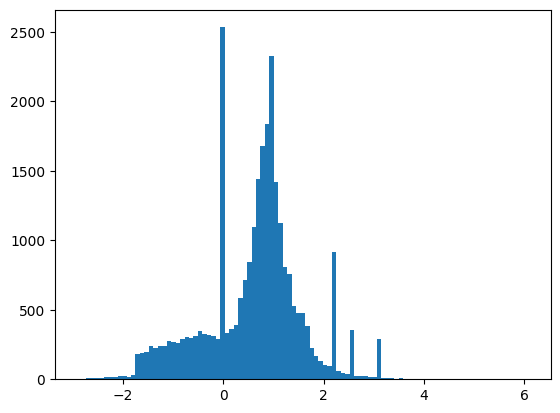

In [16]:
for features, label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins=101)

In [17]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN/BATCH_SIZE

In [18]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [19]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [20]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [21]:
#Procedura szkolenia modeli
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

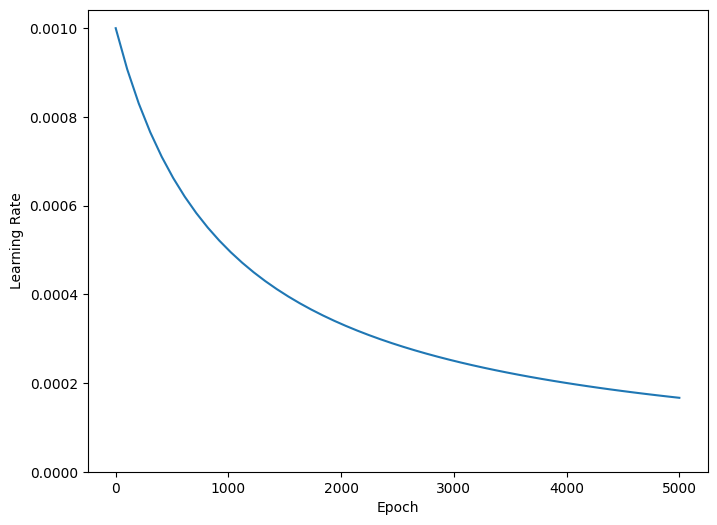

In [23]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH,lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [24]:
def get_callbacks(name):
  return [
      tfdocs.modeling.EpochDots(),
      tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience = 200),
      tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [25]:
def compile_and_fit(model,name,optimizer=None,max_epochs = 10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer = optimizer,
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics = [
                    tf.keras.losses.BinaryCrossentropy(
                        from_logits=True,
                        name='binary_crossentropy'
                    ),
                    'accuracy'
                ])

  model.summary()

  history = model.fit(
      train_ds,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs = max_epochs,
      validation_data = validate_ds,
      callbacks = get_callbacks(name),
      verbose=0
  )
  return history


In [26]:
#bardzo mały model, płytki, ML

tiny_model = tf.keras.Sequential([
    layers.Dense(16,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(1)
])


In [27]:
size_histories = {}

In [28]:
size_histories['Tiny']=compile_and_fit(tiny_model,'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481 (1.88 KB)
Trainable params: 481 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4768,  binary_crossentropy:0.7671,  loss:0.7671,  val_accuracy:0.4810,  val_binary_crossentropy:0.7454,  val_loss:0.7454,  
....................................................................................................
Epoch: 100, accuracy:0.6040,  binary_crossentropy:0.6250,  loss:0.6250,  val_accuracy:0.5660,  val_binary_crossentropy:0.6310,  val_loss:0.6310,  
............................

(0.5, 0.7)

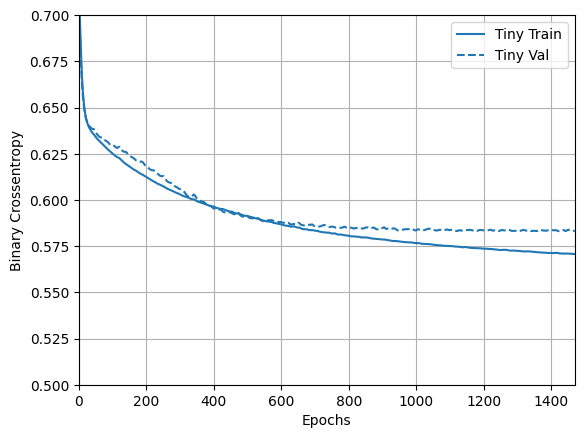

In [29]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy',smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5,0.7])

In [34]:
#mały model  - prosta sieć głęboka
small_model = tf.keras.Sequential([
    layers.Dense(16,activation="elu", input_shape=(FEATURES,)),
    layers.Dense(16,activation="elu"),
    layers.Dense(1)
])

In [33]:
size_histories['Small']=compile_and_fit(small_model,'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                464       
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753 (2.94 KB)
Trainable params: 753 (2.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.5010,  binary_crossentropy:0.7426,  loss:0.7426,  val_accuracy:0.4810,  val_binary_crossentropy:0.7098,  val_loss:0.7098,  
....................................................................................................
Epoch: 100, accuracy:0.6168,  binary_cros

In [38]:
#średni model  -  sieć głęboka
medium_model = tf.keras.Sequential([
    layers.Dense(64,activation="elu", input_shape=(FEATURES,)),
    layers.Dense(64,activation="elu"),
    layers.Dense(64,activation="elu"),
    layers.Dense(1)
])

In [37]:
size_histories['Medium']=compile_and_fit(medium_model,'sizes/Medium')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                1856      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10241 (40.00 KB)
Trainable params: 10241 (40.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4902,  binary_crossentropy:0.6993,  loss:0.6993,  val_accuracy:0.4760,  val_binary_crossentropy:0.6856,  val_loss:0.6856,  
....

In [40]:
#duży model  -  sieć głęboka
large_model = tf.keras.Sequential([
    layers.Dense(512,activation="elu", input_shape=(FEATURES,)),
    layers.Dense(512,activation="elu"),
    layers.Dense(512,activation="elu"),
    layers.Dense(512,activation="elu"),
    layers.Dense(1)
])

In [41]:
size_histories['Large']=compile_and_fit(large_model,'sizes/Large')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 512)               14848     
                                                                 
 dense_28 (Dense)            (None, 512)               262656    
                                                                 
 dense_29 (Dense)            (None, 512)               262656    
                                                                 
 dense_30 (Dense)            (None, 512)               262656    
                                                                 
 dense_31 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803329 (3.06 MB)
Trainable params: 803329 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accurac

Text(0.5, 0, 'Epochs [Log Scale]')

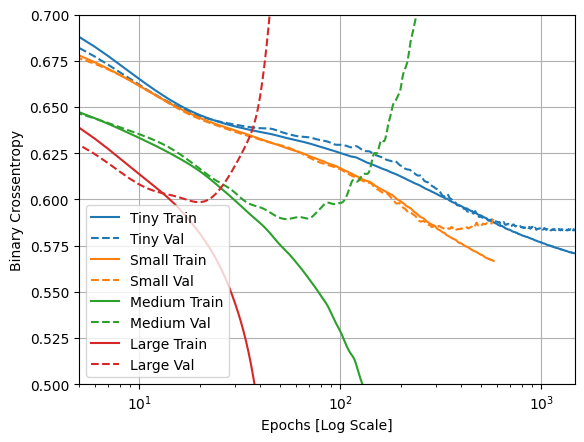

In [42]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5,max(plt.xlim())])
plt.ylim([0.5,0.7])
plt.xlabel("Epochs [Log Scale]")

STRATEGIE ZAPOBIEGANIA NADMIERNEMU DOPASOWANIU

In [43]:
shutil.rmtree(logdir/'regularizers/Tiny',ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny',logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpnfqiph5q/tensorboard_logs/regularizers/Tiny')

In [44]:
regularizers_hisotry = {}
regularizers_hisotry['Tiny'] = size_histories['Tiny']

Działanie nr1: regularyzacja wag: dodawanie do wag dodatkowego kosztu <br>
regularyzacja L1 - dodany koszt jest proporcjonalny do wartości bezwzględnej współczynników wag.<br>
regularyzacja L2 - dodany koszt jest proporcjonalny do kwadratu wartości współczynników wag.<br>
Bardziej popularnym i mocniejszym działaniem jest L2

In [48]:
l2_model = tf.keras.Sequential([
    layers.Dense(512,activation="elu", kernel_regularizer = regularizers.l2(0.001), input_shape=(FEATURES,)),
    layers.Dense(512,activation="elu",kernel_regularizer = regularizers.l2(0.001),),
    layers.Dense(512,activation="elu",kernel_regularizer = regularizers.l2(0.001),),
    layers.Dense(512,activation="elu",kernel_regularizer = regularizers.l2(0.001),),
    layers.Dense(1)
])

regularizers_hisotry['l2'] = compile_and_fit(l2_model,'regularizers/l2')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 512)               14848     
                                                                 
 dense_38 (Dense)            (None, 512)               262656    
                                                                 
 dense_39 (Dense)            (None, 512)               262656    
                                                                 
 dense_40 (Dense)            (None, 512)               262656    
                                                                 
 dense_41 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803329 (3.06 MB)
Trainable params: 803329 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accurac

(0.5, 0.7)

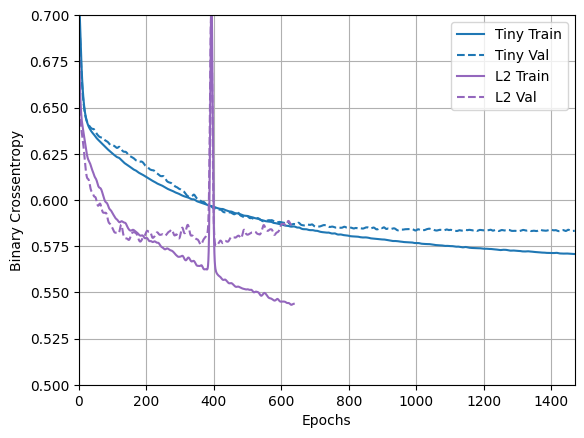

In [49]:
plotter.plot(regularizers_hisotry)
plt.ylim([0.5,0.7])

Działanie 2: Droput -  odrzucenie części wyników /wartość w procentach/

In [51]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512,activation="elu", input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512,activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(512,activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(512,activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizers_hisotry['dropout'] = compile_and_fit(dropout_model,'regularizers/dropout')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_44 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_45 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_46 (Dense)            (None, 512)             

(0.5, 0.7)

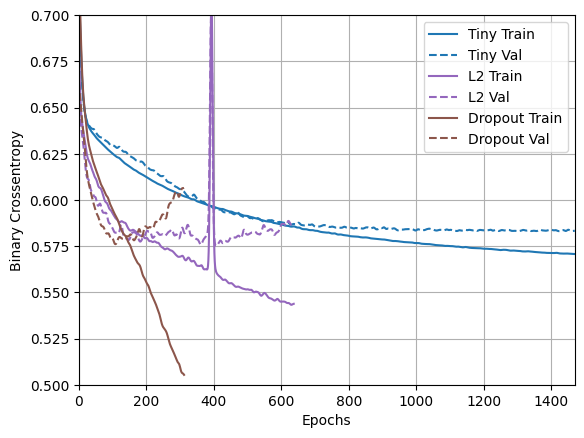

In [52]:
plotter.plot(regularizers_hisotry)
plt.ylim([0.5,0.7])

Konwencja mieszana : L2 + dropout

In [53]:
combined_model = tf.keras.Sequential([
    layers.Dense(512,activation="elu", kernel_regularizer = regularizers.l2(0.001), input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512,activation="elu",kernel_regularizer = regularizers.l2(0.001),),
    layers.Dropout(0.5),
    layers.Dense(512,activation="elu",kernel_regularizer = regularizers.l2(0.001),),
    layers.Dropout(0.5),
    layers.Dense(512,activation="elu",kernel_regularizer = regularizers.l2(0.001),),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizers_hisotry['combined'] = compile_and_fit(combined_model,'regularizers/combined')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 512)               14848     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_49 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_50 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_51 (Dense)            (None, 512)             

(0.5, 0.7)

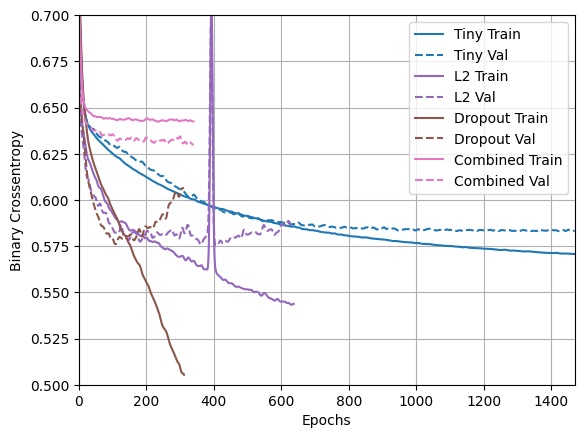

In [54]:
plotter.plot(regularizers_hisotry)
plt.ylim([0.5,0.7])